In [20]:
learning_rate = 0.0015
weight_decay = 0.0001
batch_size = 512
epochs = 6

history_count = 4
filter_size = 64
main_model_blocks = 4
move_processor_blocks = 8
use_batchnorm = False

min_elo_win = 2000
min_elo_tie = 2500

### Downloader

In [ ]:
! pip install -q python-chess
! pip install -q kaggle

! mkdir ~/.kaggle
! echo '{"username":"threetnt","key":"7454bbee8bfde646c02f2a915ea5d02a"}' > ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d milesh1/35-million-chess-games
! unzip -p 35-million-chess-games.zip all_with_filtered_anotations_since1998.txt > rawdata.txt

### Processing

In [2]:
import pandas as pd
import numpy as np
import chess.pgn
import io
import time
import os
from sklearn.utils import resample
import warnings

warnings.filterwarnings("ignore")

def board_to_array(board):
    board_state = np.zeros((6, 8, 8), dtype=np.int8)

    piece_dict = {
        'P': 0,  # White Pawn
        'R': 1,  # White Rook
        'N': 2,  # White Knight
        'B': 3,  # White Bishop
        'Q': 4,  # White Queen
        'K': 5,  # White King
    }

    for i in range(8):
        for j in range(8):
            piece = board.piece_at(chess.square(i, j))

            if piece:
                piece_str = str(piece)
                color = int(piece_str.isupper())
                layer = piece_dict[piece_str.upper()]
                board_state[layer, 7-j, i] = color*2-1
            
    return board_state

def pgn_to_states(p):
    game_states = []

    p = io.StringIO(p)
    game = chess.pgn.read_game(p)
    p.close()

    board = game.board()
    for move in game.mainline_moves():
        board.push(move)
        board_state = board_to_array(board)
        game_states.append(board_state)

    return game_states


In [ ]:
@lambda f:f()
def process():
    with open("rawdata.txt", "r") as f:
        data = f.readlines()[5:]

    filehandle = open("chess_processed_small.csv", "w")
    filehandle.write("winner,white_elo,black_elo,diff,pgn\n")

    def convert_to_pgn(move_sequence):
        moves = move_sequence.split(" ")
        pgn_moves = []
        for i in range(0, len(moves), 2):
            move_number = i // 2 + 1
            white_move = moves[i].split('.')[1]
            black_move = moves[i+1].split('.')[1] if i + 1 < len(moves) and '.' in moves[i+1] else ''
            pgn_moves.append(f"{move_number}.{white_move} {black_move}")
        return " ".join(pgn_moves)

    _time = time.time()
    _processed, _total = 0, 0

    processed_cache = ""
    for line in data:
        metadata, pgn = line.split(" ### ")
        pgn = pgn.strip()
        metadata = metadata.strip().split(" ")
        
        winner = metadata[2]
        if "blen_false" in metadata[15] and metadata[3] != "None" and metadata[4] != "None":
            welo, belo = int(metadata[3]), int(metadata[4])
            if pgn.endswith("#"):
                if welo < min_elo_win or belo < min_elo_win:
                    continue
            elif winner == "1/2-1/2":
                if welo < min_elo_tie or belo < min_elo_tie:
                    continue
            else: continue

            pgn = convert_to_pgn(pgn)
            if winner == "1-0": 
                winner = 1
            elif winner == "0-1": 
                winner = -1
            else: 
                winner = 0
            processed_cache += f"{winner},{welo},{belo},{welo - belo},{pgn}\n"
            _processed += 1
        _total += 1

        if time.time() - _time > 0.2:
            print(f"{_processed} / {_total}")
            _time = time.time()

        if _processed > 5000: # Too much data will overflow the RAM
            break

    print("done")
    filehandle.write(processed_cache)
    filehandle.close()

In [3]:
def process():
    if 'data' in os.listdir():
        if 'X.npy' in os.listdir('data') and 'Y.npy' in os.listdir('data'):
            return np.load('data/X.npy'), np.load('data/Y.npy')
    else:
        os.mkdir('data')

    df = pd.read_csv('chess_processed_small.csv')

    winner_w = df[df['winner'] == 1]
    winner_b = df[df['winner'] == -1]
    tie = df[df['winner'] == 0]

    minlen = min(len(winner_w), len(winner_b), len(tie))
    winner_w = resample(winner_w, replace=False, n_samples=minlen, random_state=1337)
    winner_b = resample(winner_b, replace=False, n_samples=minlen, random_state=1337)
    tie = resample(tie, replace=False, n_samples=minlen, random_state=1337)

    df:pd.DataFrame = pd.concat([winner_w, winner_b, tie])
    print(df['winner'].value_counts())

    X = []
    Y = []

    t = time.time()
    done = 0
    for idx, row in df.iterrows():
        states = pgn_to_states(row['pgn'])
        winner = row['winner']
        
        laststates = [np.zeros((6, 8, 8), dtype=np.int8) for i in range(4)]
        for state in states:
            laststates.pop(0)
            laststates.append(state)
            X.append(np.array(laststates).reshape((6*history_count, 8, 8)))
            Y.append(winner)
        
        if time.time() - t > 1:
            print("Done:", done, "| Time elapsed:", time.time() - t)
            t = time.time()

    X = np.array(X)
    Y = np.array(Y)

    np.save('data/X.npy', X)
    np.save('data/Y.npy', Y)

    return X, Y

X, Y = process()

### Training

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Basic block of a ResNet
class ResBlock(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(filter_size, filter_size, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(filter_size, filter_size, kernel_size=3, padding=1),
            nn.LeakyReLU(),
        ) if not use_batchnorm else nn.Sequential(
            nn.Conv2d(filter_size, filter_size, kernel_size=3, padding=1),
            nn.BatchNorm2d(filter_size),
            nn.LeakyReLU(),
            nn.Conv2d(filter_size, filter_size, kernel_size=3, padding=1),
            nn.BatchNorm2d(filter_size),
        )
    
    def forward(self, x):
        x1 = self.convs(x)
        x1 += x
        return F.leaky_relu(x1)

# Processes a single state from the last 4 states
class MoveProcessor(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(6, filter_size, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            *[ResBlock() for _ in range(move_processor_blocks)],
            nn.Conv2d(filter_size, filter_size, kernel_size=3, padding=1),
            nn.LeakyReLU(),
        )
    
    def forward(self, x):
        return self.convs(x)

# The main model
class ChessNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.move_processor = MoveProcessor()
        self.convs = nn.Sequential(
            nn.Conv2d(filter_size * history_count, filter_size, kernel_size=3, padding=1),
            *[ResBlock() for _ in range(main_model_blocks)],
            nn.Flatten(),
            nn.Linear(filter_size*8*8, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 1),
            nn.Tanh()
        )
    
    def forward(self, x):
        newx = []
        for i in range(4):
            newx.append(self.move_processor(x[:, i*6:(i+1)*6, :, :]))
        x = torch.cat(newx, dim=1)
        return self.convs(x)
    
    def predict(self, x):
        x = x.reshape(1, 6*history_count, 8, 8)
        return self.forward(x).item()

In [22]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

def train_model(model, loss_fn, optimizer, train_loader, val_loader, epochs):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)

    model = model.to(device)
    loss_fn = loss_fn.to(device)

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        batch_losses = []
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            X_batch = X_batch.to(device, dtype=torch.float32)
            y_batch = y_batch.to(device, dtype=torch.float32)

            optimizer.zero_grad()

            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)

            loss.backward()
            optimizer.step()

            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch+1}/{epochs}, Batch: {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}')

            batch_losses.append(loss.item())

        train_losses.extend(batch_losses)

        val_accuracy = 0
        val_total = 0

        with torch.no_grad():
            model.eval()
            batch_val_losses = []
            for X_val, y_val in val_loader:
                X_val = X_val.to(device, dtype=torch.float32)
                y_val = y_val.to(device, dtype=torch.float32)

                y_val_pred = model(X_val)
                val_loss = loss_fn(y_val_pred, y_val)
                batch_val_losses.append(val_loss.item())

                val_total += torch.flatten(y_val).shape[0]
                val_accuracy += (torch.flatten(y_val_pred).round() == torch.flatten(y_val)).sum().item()
            model.train()

        val_losses.extend(batch_val_losses)
        val_accuracies.append(val_accuracy/val_total)

        print(f'Epoch: {epoch+1}/{epochs}, Train Loss: {np.mean(batch_losses):.4f}, Val Loss: {np.mean(batch_val_losses):.4f}, Val Accuracy: {val_accuracy/val_total:.4f}')

        # Loss plot
        plt.figure(figsize=(12, 6))
        plt.plot(train_losses, label='Train')
        val_plot_x = np.linspace(0, 1, len(val_losses)) * len(train_losses)
        plt.plot(val_plot_x, val_losses, label='Val')
        val_plot_x = np.linspace(0, 1, len(val_accuracies)) * len(train_losses)
        plt.plot(val_plot_x, val_accuracies, label='Val accuracy')
        plt.title('Loss over epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

def train_val_test_split(X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.1, random_state=1337, shuffle=True)
    X_train, X_val, Y_train, Y_val = train_test_split(
        X_train, Y_train, test_size=0.1, random_state=1337, shuffle=True)
    return (X_train, Y_train), (X_val, Y_val), (X_test, Y_test)

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ChessNet().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [8]:
X = torch.tensor(X, dtype=torch.int8)
Y = torch.tensor(Y, dtype=torch.int8)

train, val, test = train_val_test_split(X, Y)

X_train = train[0].float()
Y_train = train[1].float().unsqueeze(1)

train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

X_val = val[0].float()
Y_val = val[1].float().unsqueeze(1)
val_dataset = TensorDataset(X_val, Y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


Using device: cuda
Epoch: 1/6, Batch: 1/540, Loss: 0.6330
Epoch: 1/6, Batch: 101/540, Loss: 0.6175
Epoch: 1/6, Batch: 201/540, Loss: 0.5465
Epoch: 1/6, Batch: 301/540, Loss: 0.5379
Epoch: 1/6, Batch: 401/540, Loss: 0.5389
Epoch: 1/6, Batch: 501/540, Loss: 0.5418
Epoch: 1/6, Train Loss: 0.5610, Val Loss: 0.5065, Val Accuracy: 0.4535


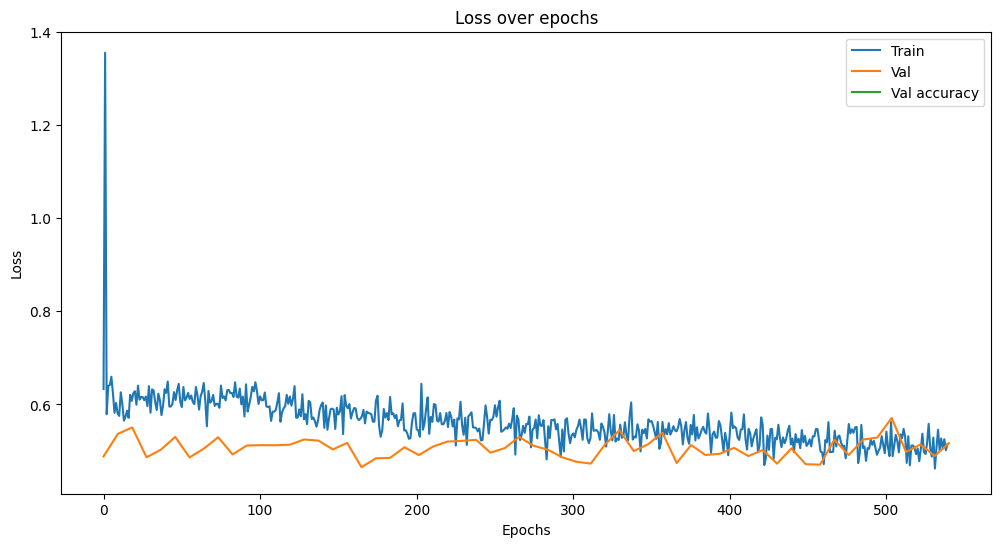

Epoch: 2/6, Batch: 1/540, Loss: 0.5513
Epoch: 2/6, Batch: 101/540, Loss: 0.4431
Epoch: 2/6, Batch: 201/540, Loss: 0.3754
Epoch: 2/6, Batch: 301/540, Loss: 0.3556
Epoch: 2/6, Batch: 401/540, Loss: 0.3626
Epoch: 2/6, Batch: 501/540, Loss: 0.3308
Epoch: 2/6, Train Loss: 0.4073, Val Loss: 0.3194, Val Accuracy: 0.6448


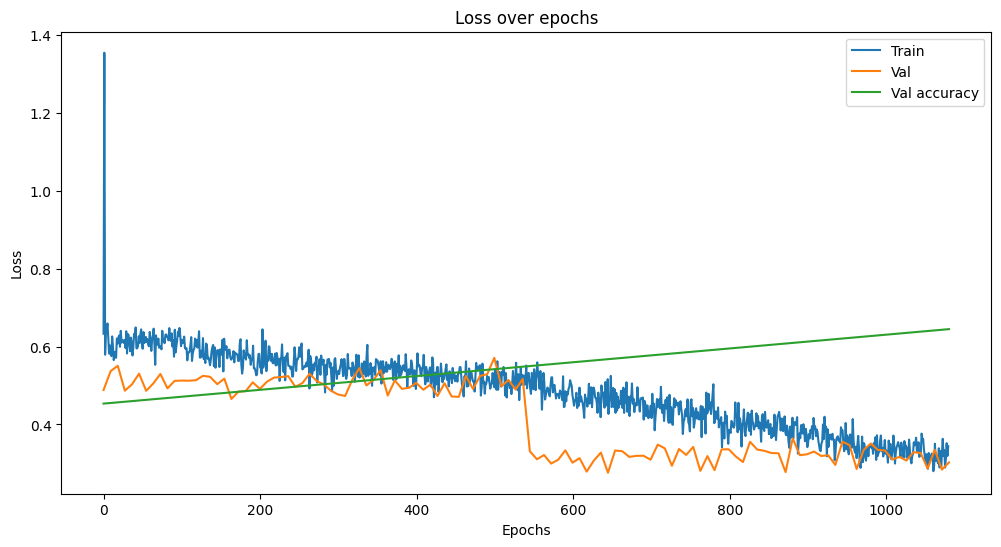

Epoch: 3/6, Batch: 1/540, Loss: 0.3006
Epoch: 3/6, Batch: 101/540, Loss: 0.2601
Epoch: 3/6, Batch: 201/540, Loss: 0.2803
Epoch: 3/6, Batch: 301/540, Loss: 0.2275
Epoch: 3/6, Batch: 401/540, Loss: 0.2255
Epoch: 3/6, Batch: 501/540, Loss: 0.2201
Epoch: 3/6, Train Loss: 0.2488, Val Loss: 0.2247, Val Accuracy: 0.7568


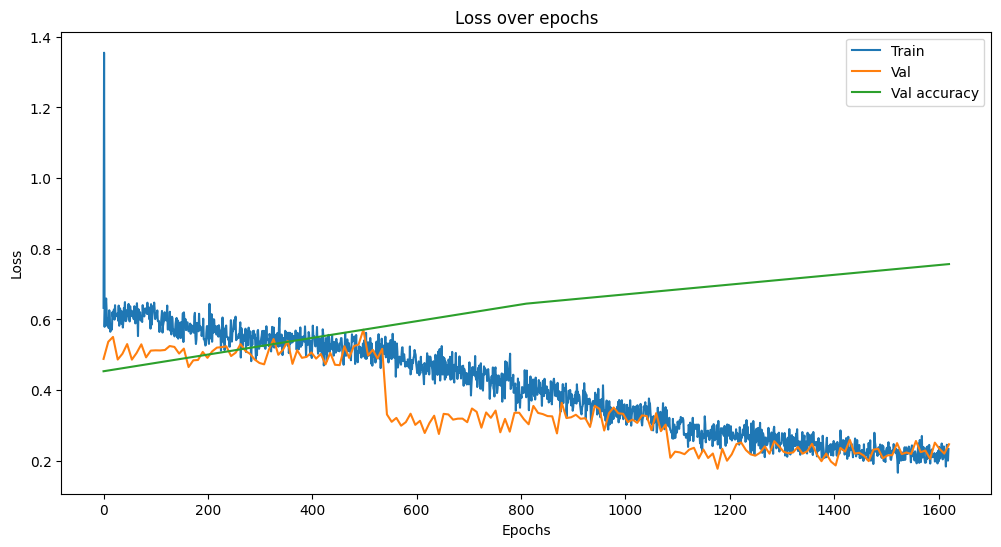

Epoch: 4/6, Batch: 1/540, Loss: 0.2342
Epoch: 4/6, Batch: 101/540, Loss: 0.1688
Epoch: 4/6, Batch: 201/540, Loss: 0.1852
Epoch: 4/6, Batch: 301/540, Loss: 0.1784
Epoch: 4/6, Batch: 401/540, Loss: 0.1533
Epoch: 4/6, Batch: 501/540, Loss: 0.1529
Epoch: 4/6, Train Loss: 0.1766, Val Loss: 0.1785, Val Accuracy: 0.8137


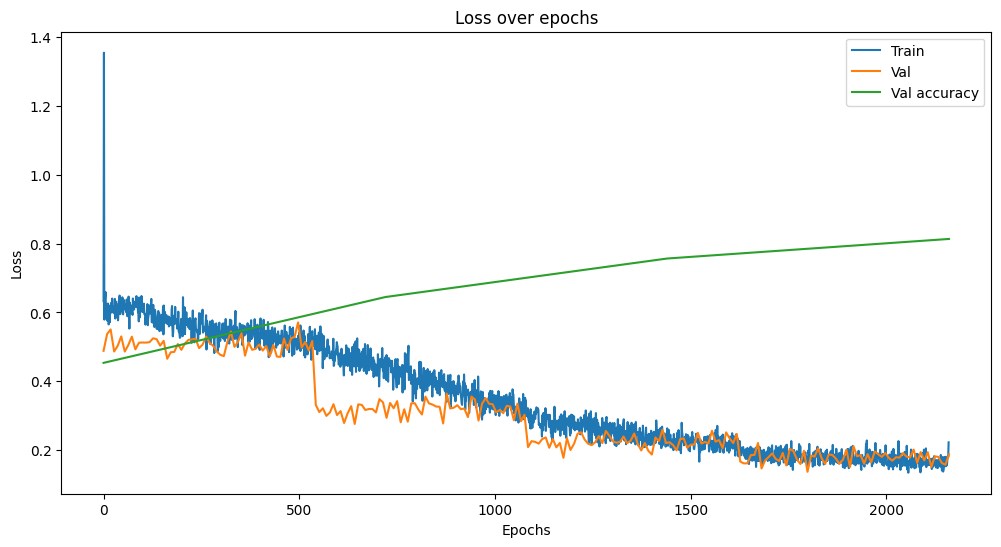

Epoch: 5/6, Batch: 1/540, Loss: 0.1515
Epoch: 5/6, Batch: 101/540, Loss: 0.1420
Epoch: 5/6, Batch: 201/540, Loss: 0.1447
Epoch: 5/6, Batch: 301/540, Loss: 0.1391
Epoch: 5/6, Batch: 401/540, Loss: 0.1576
Epoch: 5/6, Batch: 501/540, Loss: 0.1568
Epoch: 5/6, Train Loss: 0.1473, Val Loss: 0.1624, Val Accuracy: 0.8348


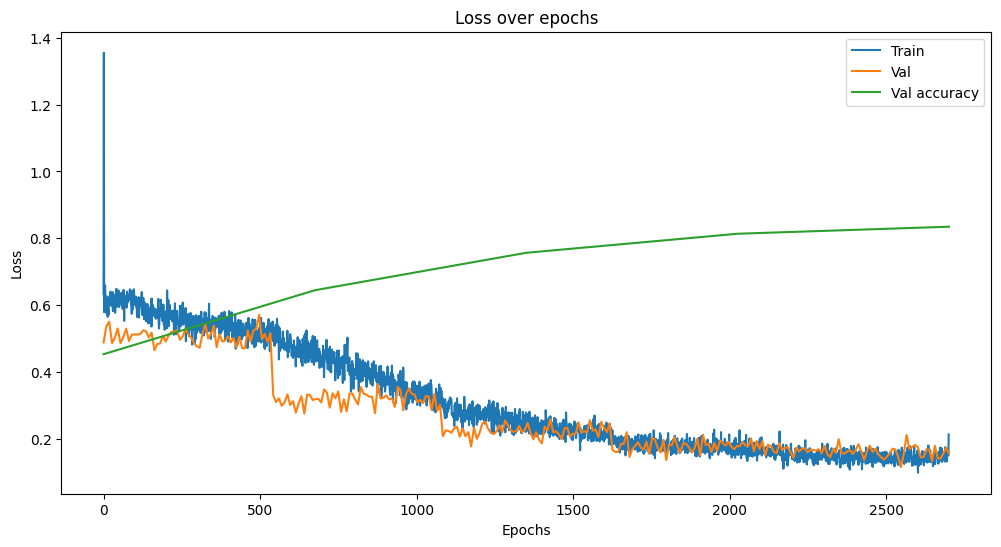

Epoch: 6/6, Batch: 1/540, Loss: 0.1267
Epoch: 6/6, Batch: 101/540, Loss: 0.1038
Epoch: 6/6, Batch: 201/540, Loss: 0.1079
Epoch: 6/6, Batch: 301/540, Loss: 0.1279
Epoch: 6/6, Batch: 401/540, Loss: 0.1249
Epoch: 6/6, Batch: 501/540, Loss: 0.1011
Epoch: 6/6, Train Loss: 0.1317, Val Loss: 0.1467, Val Accuracy: 0.8550


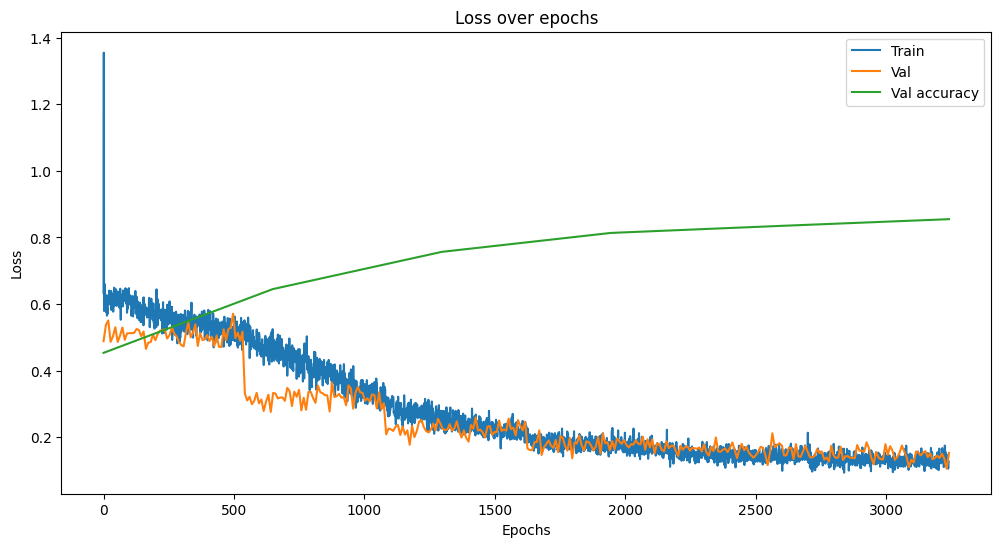

In [24]:
train_model(model, loss_fn, optimizer, train_loader, val_loader, epochs)

In [26]:
torch.jit.trace(model, torch.rand(1, 6*history_count, 8, 8, device=device)).save('models/model_full_large_resnet4.pt')